In [2]:
import importlib as imp
import glob
from functools import partial
import multiprocess as mp
from matplotlib.gridspec import GridSpec

import mirnylib
import mirnylib.plotting
import cooler
import bioframe

import scipy
from scipy.ndimage.filters import gaussian_filter1d
import scipy.sparse as sp
from scipy.signal import argrelextrema
from scipy.interpolate import interp1d

import new_scalings
import scaling_analysis
import DNA_info
import matrix_manager as mm

import multiprocess as mp

%matplotlib notebook

# Loading and Merging Scaling

In [48]:
imp.reload(mm)
db = mm.Dataset()
table = db.get_tables()
# table = mm.get_scalings(table, trans=True)
table = mm.get_coolers(table, res=1000000)

# scale_list = []
# trans_list = []
# for i, row in table.iterrows():
#     display(row['lib_name'])
    
#     if row['celltype'] == 'HelaS3':
#         chroms_to_keep = ['chr4', 'chr14', 'chr17', 'chr18', 'chr20', 'chr21']
#     else:
#         chroms_to_keep = []
    
#     scale, trans = row['scaling'].load()
    
#     scale = new_scalings.merge_regional_results(scale, regions_to_keep=chroms_to_keep, genome='hg38')
#     scale =scale.drop([0, 1000])
#     scale = new_scalings.log_binning(scale.copy())
#     scale['prob'] = scale['total']/scale['valid_bins']
    
#     if len(chroms_to_keep):

#         trans = trans.reset_index()
#         mask1 = trans.chrom1.apply(lambda x: x in chroms_to_keep)
#         mask2 = trans.chrom2.apply(lambda x: x in chroms_to_keep)
#         mask = mask1 & mask2
#         trans = trans[mask]

#     trans['prob'] = trans['total']/trans['valid_bins']
    
#     scale_list.append(scale)
#     trans_list.append(trans)
    
# table['scaling'] = scale_list
# table['trans'] = trans_list

# del scale_list
# del trans_list

# Scalings by celltype, split by enzyme and colored by xlink

In [ ]:
grey_alpha=0.35
colors = {'DSG':'r', 'EGS':'g','FA':'b'}
savepath = '/home/sameer/Dropbox (MIT)/Research/U54_matrix/scalings/celltype/'

df = mm.filter_data(table, filter_dict={'celltype':['END','ESC','HFF'],'seq':['control','-'], 'cycle':'NS'})
# df = mm.filter_data(table, filter_dict={'celltype':'HelaS3','seq':['control','-']})

for ct, big_group in df.groupby('celltype'):
# for ct, big_group in df.groupby('cycle'):
    ncols = len(big_group['enzyme'].unique())
        
    fig , ax = plt.subplots(nrows=2, ncols=ncols, figsize=(np.ceil(5*ncols/2),5), 
                            sharex=True, constrained_layout=True)
    fig.suptitle(f'Scalings for {ct}', fontsize=20, fontweight='bold')
    
    for i, row in big_group.iterrows():
            
        scale = row['scaling']
        x = scale.index.values
        y = scale['prob'].values
        
        der = scaling_analysis.finite_difference(scale, 1)
        der_x = der.index.values
        der_y = der.der.values
            
        for k in range(ncols):
            ax[0,k].set_xscale('log')
            ax[0,k].set_yscale('log')
            ax[1,k].set_xscale('log')
            ax[0,k].plot(x, y, color='grey', linestyle='-', alpha=grey_alpha)
            ax[1,k].plot(der_x, der_y, color='grey', linestyle='-', alpha=grey_alpha)

    for i, (enz, lil_group) in enumerate(big_group.groupby('enzyme')):
        r = i//2
        c = i%2

        ax[0,i].set_title(f'Enzyme: {enz}')

        for _, row in lil_group.iterrows():
                
            scale = row['scaling']
            x = scale.index.values
            y = scale['prob'].values

            trans = row['trans']
            mean_trans = trans['total'].sum()/trans['valid_bins'].sum()
            
            ax[0,i].plot(x, y, color=colors[row['xlink']], linestyle='-', label=row['xlink'])
            ax[0,i].axhline(mean_trans, color=colors[row['xlink']], linestyle=':')
               
            der = scaling_analysis.finite_difference(scale, 1)
            der_x = der.index.values
            der_y = der.der.values
            
            ax[1,i].plot(der_x, der_y, color=colors[row['xlink']], linestyle='-', label=row['xlink'])
            
        ax[0, i].legend()
    savename = f'{ct}.pdf'
    fig.savefig(f'{savepath}{savename}', format='pdf')
    savename = f'{ct}.png'
    fig.savefig(f'{savepath}{savename}', format='png')

# Scalings for deep data by celltype, colored by xlink and enzyme

In [ ]:
grey_alpha=0.35
colors = {'DSG-MNase':'tab:blue', 'DSG-DdeI':'tab:red', 'DSG-DpnII':'tab:green', 
          'FA-DpnII':'tab:purple', 'DSG-DdeI+DpnII':'tab:brown'}

savepath = '/home/sameer/Dropbox (MIT)/Research/U54_matrix/scalings/deep/'

df = mm.filter_data(table, filter_dict={'celltype':['END','ESC','HFF'], 'seq':'deep'})
    
for ct, big_group in df.groupby('celltype'):
    print(ct)
    ncols = len(big_group[cat].unique())
        
    fig , ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 4), sharex=True, constrained_layout=True)
    fig.suptitle(f'Scalings for {ct} deep data', fontsize=20, fontweight='bold')
    ax[0].set_xscale('log')
    ax[0].set_yscale('log')
    ax[1].set_xscale('log')
    for i, row in big_group.iterrows():
        xlink = row['xlink']
        enz = row['enzyme']
        if enz == 'double':
            enz = 'DdeI+DpnII'
            
        scale = row['scaling']
        x = scale.index.values
        y = scale['prob'].values
        
        trans = row['trans']
        mean_trans = trans['total'].sum()/trans['valid_bins'].sum()
        
        der = scaling_analysis.finite_difference(scale, 1)
        der_x = der.index.values
        der_y = der.der.values
        
        ax[0].plot(x, y, color=colors[f'{xlink}-{enz}'], linestyle='-', label=f'{xlink}-{enz}')
        ax[0].axhline(mean_trans, color=colors[f'{xlink}-{enz}'], linestyle=':')
        ax[1].plot(der_x, der_y, color=colors[f'{xlink}-{enz}'], linestyle='-', label=f'{xlink}-{enz}')
            
        ax[0].legend()
    savename = f'{ct}.pdf'
    fig.savefig(f'{savepath}{savename}', format='pdf')
    savename = f'{ct}.png'
    fig.savefig(f'{savepath}{savename}', format='png')

# Scalings for Hela by enzyme, split by xlink and colored by cycle

In [ ]:
grey_alpha=0.35
colors = {'G1':'r', 'M':'g','NS':'b'}
savepath = '/home/sameer/Dropbox (MIT)/Research/U54_matrix/scalings/cell_cycle/'

df = mm.filter_data(table, filter_dict={'celltype':'HelaS3','seq':['control','-']})

for xl, big_group in df.groupby('xlink'):
    
    ncols = len(big_group['enzyme'].unique())
        
    fig , ax = plt.subplots(nrows=2, ncols=ncols, figsize=(np.ceil(5*ncols/2),5), 
                            sharex=True, constrained_layout=True)
    fig.suptitle(f'Scalings for Hela crosslinked with {xl}', fontsize=20, fontweight='bold')
    
    for i, row in big_group.iterrows():
            
        scale = row['scaling']
        x = scale.index.values
        y = scale['prob'].values
        
        der = scaling_analysis.finite_difference(scale, 1)
        der_x = der.index.values
        der_y = der.der.values
            
        for k in range(ncols):
            ax[0,k].set_xscale('log')
            ax[0,k].set_yscale('log')
            ax[1,k].set_xscale('log')
            ax[0,k].plot(x, y, color='grey', linestyle='-', alpha=grey_alpha)
            ax[1,k].plot(der_x, der_y, color='grey', linestyle='-', alpha=grey_alpha)

    for i, (enz, lil_group) in enumerate(big_group.groupby('enzyme')):
        r = i//2
        c = i%2

        ax[0,i].set_title(f'Enzyme: {enz}')

        for _, row in lil_group.iterrows():
                
            scale = row['scaling']
            x = scale.index.values
            y = scale['prob'].values

            trans = row['trans']
            mean_trans = trans['total'].sum()/trans['valid_bins'].sum()
            
            ax[0,i].plot(x, y, color=colors[row['cycle']], linestyle='-', label=row['cycle'])
            ax[0,i].axhline(mean_trans, color=colors[row['cycle']], linestyle=':')
               
            der = scaling_analysis.finite_difference(scale, 1)
            der_x = der.index.values
            der_y = der.der.values
            
            ax[1,i].plot(der_x, der_y, color=colors[row['cycle']], linestyle='-', label=row['cycle'])
            
        ax[0, i].legend()
    savename = f'HelaS3_{xl}.pdf'
    fig.savefig(f'{savepath}{savename}', format='pdf')
    savename = f'HelaS3_{xl}.png'
    fig.savefig(f'{savepath}{savename}', format='png')

# Extracting metrics of the scaling

In [50]:
# slope_mean = []
# slope_sd = []
# short_slope = []
# med_slope = []
# long_slope = []
# trans_mean = []
# trans_sd = []
cis_trans = []
for i, row in table.iterrows():
    print(row['lib_name'])
#     scaling = row['scaling']
#     trans = row['trans']
#     der = scaling_analysis.finite_difference(scaling, 1).reset_index()
    
#     x = der['bins'].values
#     arr = der['der'].values
#     slope_mean.append(np.mean(arr))
#     slope_sd.append(np.sqrt(np.var(arr)))
    
#     mask = (x < 10**5)
#     short_slope.append(np.mean(arr[mask]))
    
#     mask = (x >= 10**5)&(x < 3.5*10**6)
#     med_slope.append(np.mean(arr[mask]))
    
#     mask = (x >= 3.5*10**6)
#     long_slope.append(np.mean(arr[mask]))
    
#     arr = trans['prob'].values
#     trans_mean.append(np.mean(arr))
#     trans_sd.append(np.sqrt(np.var(arr)))
    
    if row['celltype'] == 'HelaS3':
        chroms_to_keep = ['chr4', 'chr14', 'chr17', 'chr18', 'chr20', 'chr21']
    else:
        chroms_to_keep = []
    
    cool = row['cooler_1000000']
    pix = cool.pixels()[:]
    bins = cool.bins()[:]
    pix = cooler.annotate(pix, bins, replace=True)
    pix['count'] = pix['count']*pix['weight1']*pix['weight2']
    if len(chroms_to_keep):
        mask1 = pix.chrom1.apply(lambda x: x in chroms_to_keep)
        mask2 = pix.chrom2.apply(lambda x: x in chroms_to_keep)
        mask = mask1 | mask2
        pix = pix.loc[mask]

    cis = pix.loc[pix['chrom1'] == pix['chrom2'], 'count'].sum()
    trans = pix.loc[pix['chrom1'] != pix['chrom2'], 'count'].sum()
    
    cis_trans.append(cis/trans)
    
# table['mean_slope'] = slope_mean
# table['mean_trans'] = trans_mean
# table['cis_trans'] = cis_trans
# table['mean_slope_short'] = short_slope
# table['mean_slope_med'] = med_slope
# table['mean_slope_long'] = long_slope
# table['sd_slope'] = slope_sd
# table['sd_trans'] = trans_sd


U54-END-DSG-DdeI-20161031-R1-T1__hg38
U54-END-DSG-DpnII-20190711-R2-T1__hg38
U54-END-DSG-HindIII-20161206-R1-T1__hg38
U54-END-DSG-MNase-20170508-R1-T1__hg38
U54-END4DN-FA-DSG-MNase-R1-R2_hg38
U54-END-EGS-DdeI-20161219-R1-T1__hg38
U54-END-EGS-DpnII-20170119-R2-T1__hg38
U54-END-EGS-HindIII-20161219-R1-T1__hg38
U54-END-EGS-MNase-20170508-R1-T1__hg38
U54-END-FA-DdeI-20161118-R1-T1__hg38
U54-END-FA-DpnII-20170119-R2-T1__hg38
U54-END-FA-DpnII-R1-R2_hg38
U54-END-FA-HindIII-20160311-R1-T1__hg38
U54-END-FA-MNase-20170508-R1-T1__hg38
U54-ESC-DSG-DdeI-20161014-R1-T1__hg38
U54-ESC-DSG-DpnII-20160722-R1-T1__hg38
U54-ESC4DN-DSG-DpnII-R1-R2_hg38
U54-ESC-DSG-HindIII-20161206-R1-T1__hg38
U54-ESC-DSG-MNase-20170508-R2-T1__hg38
U54-H1ESC4DN-FA-DSG-MNase-R1-R2_hg38
U54-ESC-EGS-DdeI-20161118-R1-T1__hg38
U54-ESC-EGS-DpnII-20170119-R2-T1__hg38
U54-ESC-EGS-HindIII-20161206-R1-T1__hg38
U54-ESC-EGS-MNase-20170508-R1-T1__hg38
U54-ESC-FA-DdeI-20190711-R2-T1__hg38
U54-ESC-FA-DpnII-20170119-R2-T1__hg38
U54-ESC4DN-F

In [55]:
cis_trans

[2.1046864808181405,
 2.9937076718505846,
 2.732663973637306,
 4.8395223902335065,
 2.529665718162551,
 4.526223619517858,
 5.123233902842799,
 4.040222353782952,
 4.805572214446541,
 1.5856603413536012,
 1.5738020339115304,
 1.5192396476650878,
 1.9874247000870369,
 2.280928285575769,
 2.7219916444717898,
 3.71666981643717,
 4.858803953066227,
 2.3808373248659445,
 11.756792838858305,
 7.138148673070682,
 2.929157948552935,
 3.272086565682236,
 2.9796764121308437,
 15.687619416202665,
 2.0617295913738283,
 1.3164790048043704,
 1.0859816531110906,
 2.6311851309094805,
 3.061147618455162,
 3.86109772506062,
 12.683513051537807,
 5.697810682097354,
 10.467170623899024,
 8.583678037950385,
 11.767630599854805,
 18.274278427801743,
 10.322847065597022,
 2.8271804203163935,
 3.8773600630647302,
 7.343262182529681,
 24.616683907543575,
 2.6242825749503775,
 1.5335120115773313,
 2.585877197950032,
 6.621713482766338,
 2.1215829635532923,
 4.8440812084917795,
 8.962131252570106,
 5.07954916294

# Visualizing metrics

In [64]:
db = mm.Dataset()
table = db.get_tables('scaling_metrics')
table['cis_trans'] = cis_trans

<IPython.core.display.Javascript object>


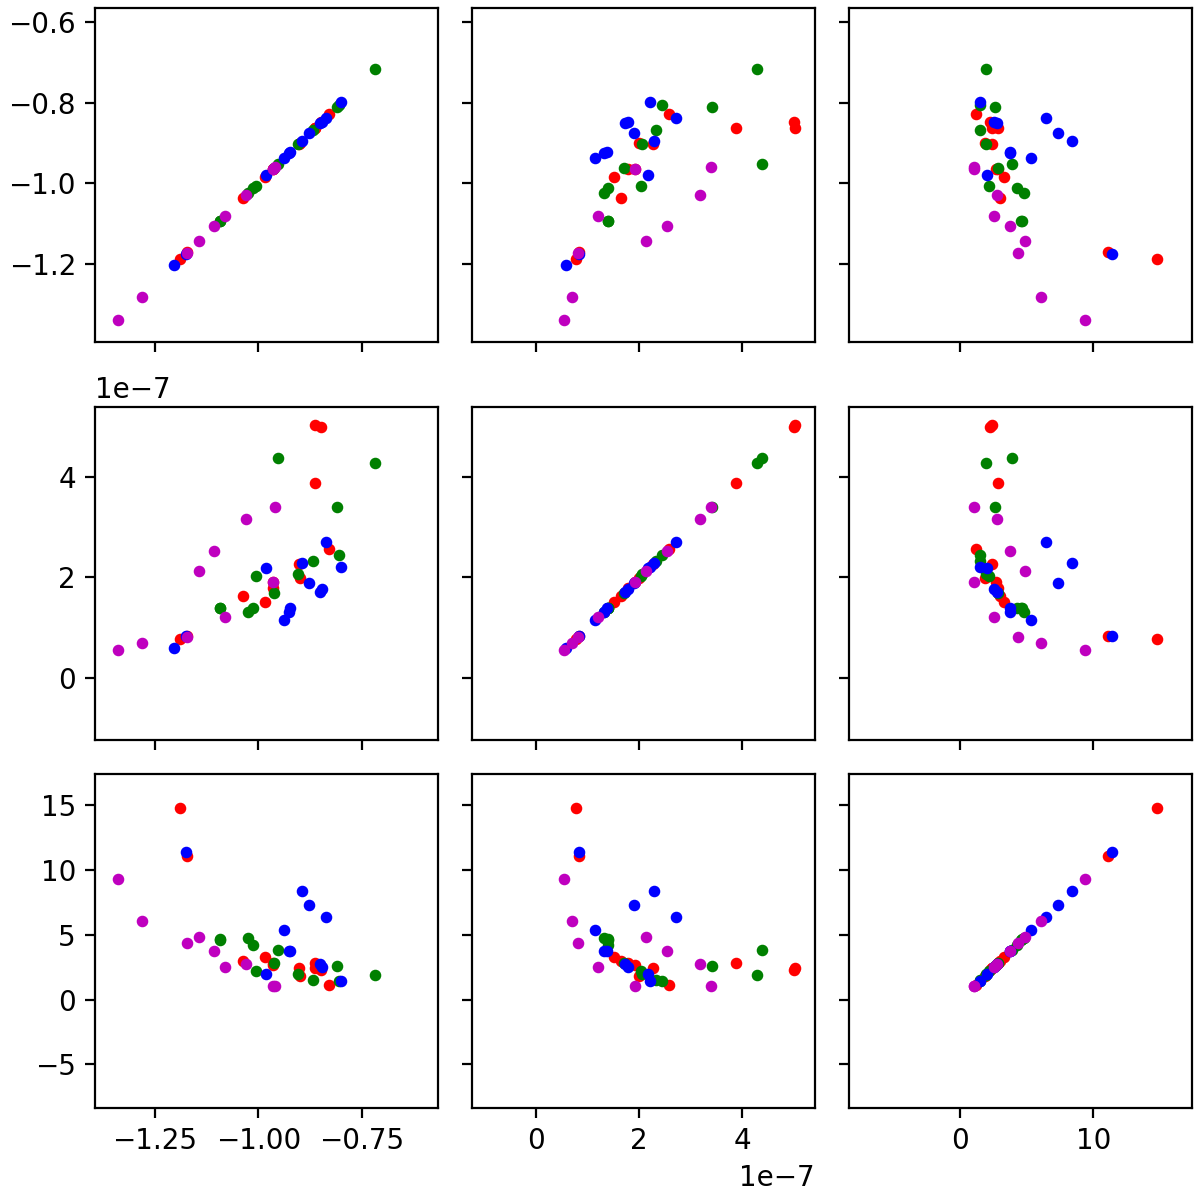

mean_slope
mean_trans
cis_trans


In [31]:
df = mm.filter_data(table, filter_dict={'seq':['control','-'], 'cycle':'NS'}).sort_index()

features = ['mean_slope', 'mean_trans', 'cis_trans']#,'sd_slope', 'sd_trans',
            #'mean_slope_short', 'mean_slope_med', 'mean_slope_long']
fig, ax = plt.subplots(nrows=len(features), ncols=len(features), figsize=(6,6), constrained_layout=True)

cat, colors = 'celltype', {'ESC':'r','END':'g','HFF':'b','HelaS3':'m'}
# cat, colors = 'enzyme', {'MNase':'b','DdeI':'m','DpnII':'r','HindIII':'g'}
# cat, colors = 'xlink', {'DSG':'r','EGS':'g','FA':'b'}
for i, feat1 in enumerate(features):
    print(feat1)
    for j, feat2 in enumerate(features):
        y = df[feat1].values
        x = df[feat2].values
        
#         corr = np.round(scipy.stats.spearmanr(x,y)[0], 2)
        for k in colors.keys():
            mask = (df[cat].values == k)
            ax[i,j].scatter(x[mask], y[mask], color=colors[k], s=10)#label=corr)
        
        mu = np.mean(x)
        sd = np.sqrt(np.var(x))
        ax[i,j].set_xlim([mu-3*sd, mu+3*sd])
        
        mu = np.mean(y)
        sd = np.sqrt(np.var(y))
        ax[i,j].set_ylim([mu-3*sd, mu+3*sd])
        if i == len(features)-1:
            pass
#             ax[i,j].set_xlabel(feat2)
        else:
            ax[i,j].set_xticklabels([])
        if j == 0:
            pass
#             ax[i,j].set_ylabel(feat1)
        else:
            ax[i,j].set_yticklabels([])


### Mean Trans v/s Scaling Slope

In [ ]:
df = mm.filter_data(table, filter_dict={'seq':['control','-'], 'cycle':'NS'}).sort_index()
fig, ax = plt.subplots(figsize=(6,6), constrained_layout=True)

cat, colors = 'celltype', {'ESC':'r','END':'g','HFF':'b','HelaS3':'m'}

y = df['mean_trans'].values
x = df['mean_slope_long'].values

for k in colors.keys():
    mask = (df[cat].values == k)
    corr = np.round(scipy.stats.spearmanr(x[mask], y[mask])[0], 2)
    ax.scatter(x[mask], y[mask], color=colors[k], s=30, label=f'{k}: {corr}')

ax.legend()
mu = np.mean(x)
sd = np.sqrt(np.var(x))
ax.set_xlim([mu-3*sd, mu+3*sd])

mu = np.mean(y)
sd = np.sqrt(np.var(y))
ax.set_ylim([0, mu+3*sd])
ax.set_title(f'Trans Level v/s Scaling Slope', fontweight='bold')
ax.set_xlabel('Average Slope of P(s)', fontweight='bold')  
ax.set_ylabel('Average Trans Level', fontweight='bold')
savepath = '/home/sameer/Dropbox (MIT)/Research/U54_matrix/scatterplots/draft_figs/cis_trans/'
# fig.savefig(f'{savepath}trans_celltype.pdf', format='pdf')
# fig.savefig(f'{savepath}trans_celltype.png', format='png')

In [ ]:
grey_alpha=0.35
enz_colors = {'MNase':'b','DdeI':'m','DpnII':'r','HindIII':'g'}
xl_colors = {'DSG':'r', 'EGS':'g','FA':'b'}
savepath = '/home/sameer/Dropbox (MIT)/Research/U54_matrix/scatterplots/draft_figs/cis_trans/'

df = mm.filter_data(table, filter_dict={'seq':['control','-'], 'cycle':'NS'})

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(12,6), sharex=True, sharey=True, constrained_layout=True)
fig.suptitle('Trans Level v/s Scaling Slope', fontsize=20, fontweight='bold')
ax[0,0].set_ylabel('Average Trans Level', fontweight='bold')
ax[1,0].set_ylabel('Average Trans Level', fontweight='bold')

x = df['mean_slope_long'].values
y = df['mean_trans'].values

mux = np.mean(x)
sdx = np.sqrt(np.var(x))
muy = np.mean(y)
sdy = np.sqrt(np.var(y))

for k in range(4):
    ax[0,k].scatter(x, y, color='grey', s=20, alpha=grey_alpha)
    ax[1,k].scatter(x, y, color='grey', s=20, alpha=grey_alpha)
    ax[0,k].set_xlim([mux-3*sdx, mux+3*sdx])
    ax[1,k].set_xlim([mux-3*sdx, mux+3*sdx])
    ax[0,k].set_ylim([0, muy+3*sdy])
    ax[1,k].set_ylim([0, muy+3*sdy])
            
for i, (ct, big_group) in enumerate(df.groupby('celltype')):
    ax[0,i].set_title(f'{ct}')
    ax[1,i].set_xlabel('Average Slope of P(s)', fontweight='bold')    

    for enz, lil_group in big_group.groupby('enzyme'):
        
        x = lil_group['mean_slope_long'].values
        y = lil_group['mean_trans'].values

        ax[0,i].scatter(x, y, color=enz_colors[enz], s=20, label=enz)
    ax[0, i].legend()
    
    for xl, lil_group in big_group.groupby('xlink'):
        
        x = lil_group['mean_slope_long'].values
        y = lil_group['mean_trans'].values

        ax[1,i].scatter(x, y, color=xl_colors[xl], s=20, label=xl)
    ax[1, i].legend()
    
fig.savefig(f'{savepath}trans_protocol_long.pdf', format='pdf')
# fig.savefig(f'{savepath}trans_protocol.png', format='png')

### Trans % v/s Scaling Slope

<IPython.core.display.Javascript object>


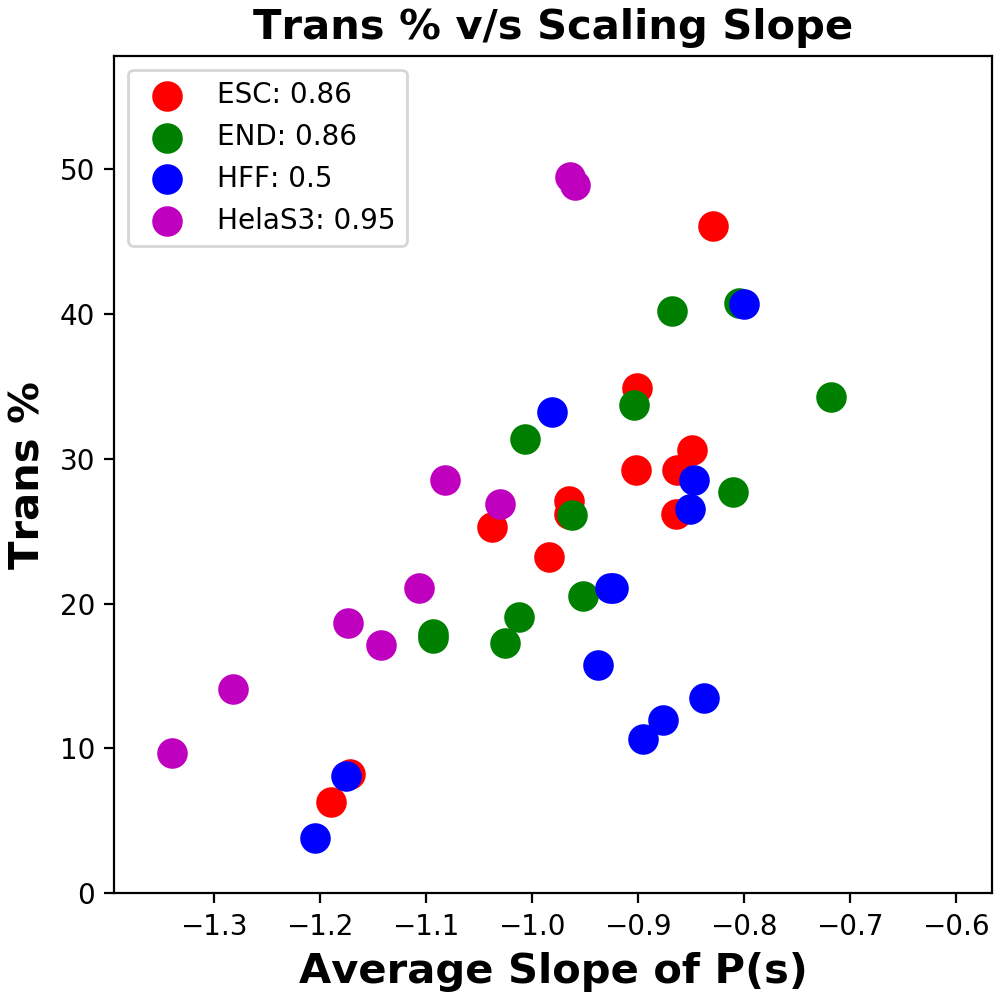

In [36]:
df = mm.filter_data(table, filter_dict={'seq':['control','-'], 'cycle':'NS'}).sort_index()
fig, ax = plt.subplots(figsize=(5,5), constrained_layout=True)

colors = {'ESC':'r','END':'g','HFF':'b','HelaS3':'m'}

y = df['cis_trans'].values
y = 100/(1+y)
x = df['mean_slope'].values

for k in colors.keys():
    mask = (df['celltype'].values == k)
    corr = np.round(scipy.stats.spearmanr(x[mask], y[mask])[0], 2)
    ax.scatter(x[mask], y[mask], color=colors[k], s=100, label=f'{k}: {corr}')

ax.legend()
mu = np.mean(x)
sd = np.sqrt(np.var(x))
ax.set_xlim([mu-3*sd, mu+3*sd])

mu = np.mean(y)
sd = np.sqrt(np.var(y))
ax.set_ylim([0, mu+3*sd])
ax.set_title(f'Trans % v/s Scaling Slope', fontsize=15, fontweight='bold')
ax.set_xlabel('Average Slope of P(s)', fontsize=15, fontweight='bold')  
ax.set_ylabel('Trans %', fontsize=15, fontweight='bold')
savepath = '/home/sameer/Dropbox (MIT)/Research/U54_matrix/scatterplots/draft_figs/cis_trans/'
fig.savefig(f'{savepath}scatter_trans%_v_slope_celltype.pdf', format='pdf')

<IPython.core.display.Javascript object>


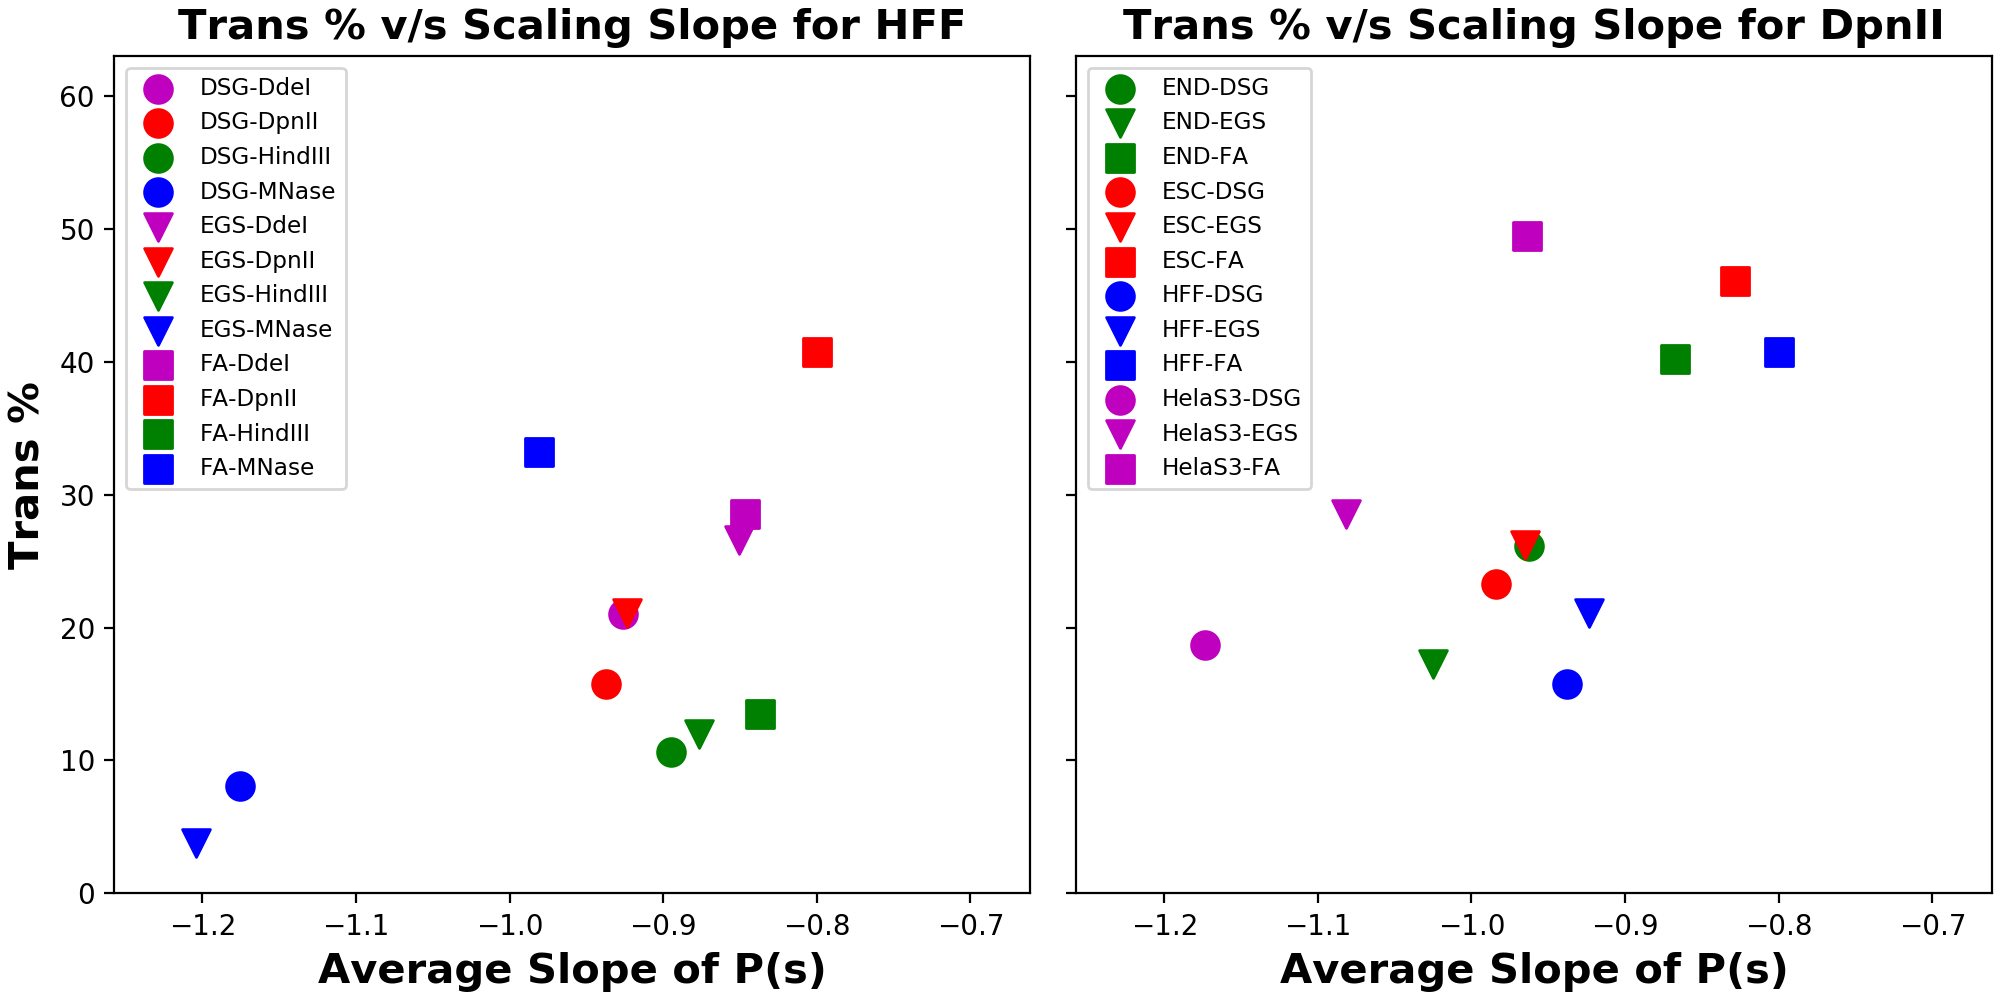

In [61]:
df = mm.filter_data(table, filter_dict={'celltype':'HFF','seq':['control','-'], 'cycle':'NS'}).sort_index()
fig, ax = plt.subplots(ncols=2, figsize=(10,5), sharex=True, sharey=True, constrained_layout=True)

colors = {'MNase':'b','DdeI':'m','DpnII':'r','HindIII':'g'}
markers = {'DSG':'o', 'EGS':'v','FA':'s'}

y = df['cis_trans'].values
y = 100/(1+y)
x = df['mean_slope'].values
mu = np.mean(x)
sd = np.sqrt(np.var(x))
ax[0].set_xlim([mu-3*sd, mu+3*sd])
mu = np.mean(y)
sd = np.sqrt(np.var(y))
ax[0].set_ylim([0, mu+3*sd])

for _, row in df.iterrows():
    xl = row['xlink']
    enz = row['enzyme']
    x1 = row['mean_slope']
    y1 = row['cis_trans']
    y1 = 100/(1+y1)
    ax[0].scatter(x1, y1, s=100, color=colors[enz], marker=markers[xl], label=f'{xl}-{enz}')

ax[0].legend(loc='best', fontsize='small')

ax[0].set_title(f'Trans % v/s Scaling Slope for HFF', fontsize=15, fontweight='bold')
ax[0].set_xlabel('Average Slope of P(s)', fontsize=15, fontweight='bold')  
ax[0].set_ylabel('Trans %', fontsize=15, fontweight='bold')


df = mm.filter_data(table, filter_dict={'enzyme':'DpnII','seq':['control','-'], 'cycle':'NS'}).sort_index()


colors = {'ESC':'r','END':'g','HFF':'b','HelaS3':'m'}

y = df['cis_trans'].values
y = 100/(1+y)
x = df['mean_slope'].values
mu = np.mean(x)
sd = np.sqrt(np.var(x))
ax[1].set_xlim([mu-3*sd, mu+3*sd])
mu = np.mean(y)
sd = np.sqrt(np.var(y))
ax[1].set_ylim([0, mu+3*sd])

for _, row in df.iterrows():
    xl = row['xlink']
#     enz = row['enzyme']
    ct = row['celltype']
    x1 = row['mean_slope']
    y1 = row['cis_trans']
    y1 = 100/(1+y1)
    ax[1].scatter(x1, y1, s=100, color=colors[ct], marker=markers[xl], label=f'{ct}-{xl}')

ax[1].legend(loc='best', fontsize='small')

ax[1].set_title(f'Trans % v/s Scaling Slope for DpnII', fontsize=15, fontweight='bold')
ax[1].set_xlabel('Average Slope of P(s)', fontsize=15, fontweight='bold')  
savepath = '/home/sameer/Dropbox (MIT)/Research/U54_matrix/scatterplots/draft_figs/cis_trans/'
# fig.savefig(f'{savepath}scatter_trans%_v_slope_fig_2d_2e.pdf', format='pdf')

<IPython.core.display.Javascript object>


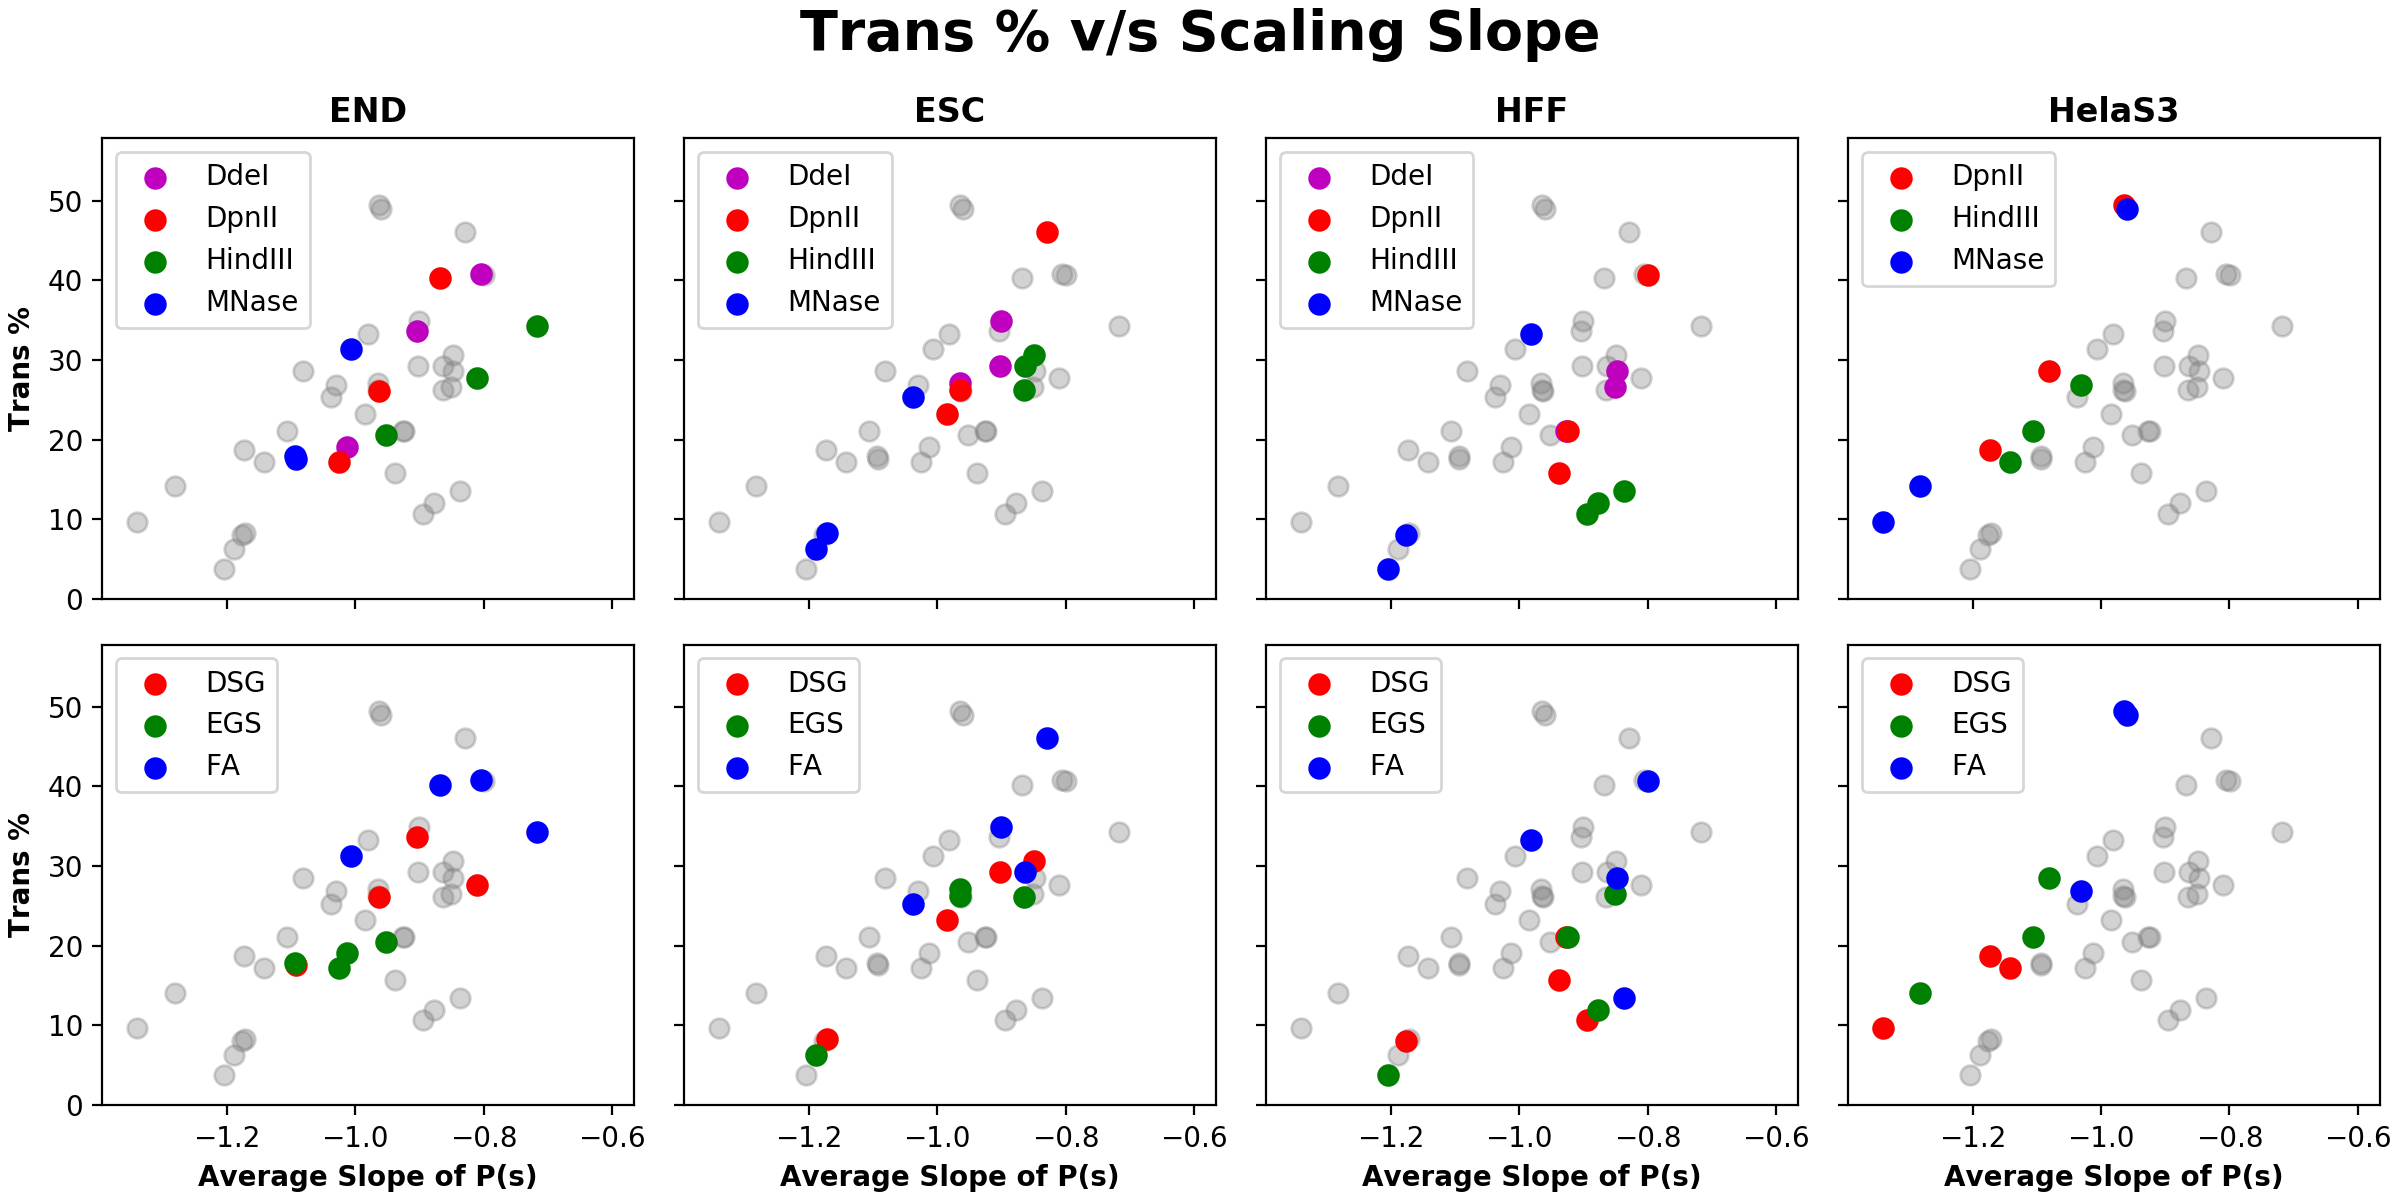

In [40]:
grey_alpha=0.35
enz_colors = {'MNase':'b','DdeI':'m','DpnII':'r','HindIII':'g'}
xl_colors = {'DSG':'r', 'EGS':'g','FA':'b'}
savepath = '/home/sameer/Dropbox (MIT)/Research/U54_matrix/scatterplots/draft_figs/cis_trans/'

df = mm.filter_data(table, filter_dict={'seq':['control','-'], 'cycle':'NS'})

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(12,6), sharex=True, sharey=True, constrained_layout=True)
fig.suptitle('Trans % v/s Scaling Slope', fontsize=20, fontweight='bold')
ax[0,0].set_ylabel('Trans %', fontweight='bold')
ax[1,0].set_ylabel('Trans %', fontweight='bold')

x = df['mean_slope'].values
y = df['cis_trans'].values
y = 100/(1+y)

mux = np.mean(x)
sdx = np.sqrt(np.var(x))
muy = np.mean(y)
sdy = np.sqrt(np.var(y))

for k in range(4):
    ax[0,k].scatter(x, y, color='grey', s=50, alpha=grey_alpha)
    ax[1,k].scatter(x, y, color='grey', s=50, alpha=grey_alpha)
    ax[0,k].set_xlim([mux-3*sdx, mux+3*sdx])
    ax[1,k].set_xlim([mux-3*sdx, mux+3*sdx])
    ax[0,k].set_ylim([0, muy+3*sdy])
    ax[1,k].set_ylim([0, muy+3*sdy])
            
for i, (ct, big_group) in enumerate(df.groupby('celltype')):
    ax[0,i].set_title(f'{ct}', fontweight='bold')
    ax[1,i].set_xlabel('Average Slope of P(s)', fontweight='bold') 
    
#     y = big_group['cis_trans'].values
#     y = 100/(1+y)
#     muy = np.mean(y)
#     sdy = np.sqrt(np.var(y))
#     ax[0,i].set_ylim([0, muy+4*sdy])
#     ax[1,i].set_ylim([0, muy+4*sdy])

    for enz, lil_group in big_group.groupby('enzyme'):
        
        x = lil_group['mean_slope'].values
        y = lil_group['cis_trans'].values
        y = 100/(1+y)
        ax[0,i].scatter(x, y, color=enz_colors[enz], s=50, label=enz)
    ax[0, i].legend()
    
    for xl, lil_group in big_group.groupby('xlink'):
        
        x = lil_group['mean_slope'].values
        y = lil_group['cis_trans'].values
        y = 100/(1+y)
        ax[1,i].scatter(x, y, color=xl_colors[xl], s=50, label=xl)
    ax[1, i].legend()
    
fig.savefig(f'{savepath}scatter_trans%_v_slope_protocol.pdf', format='pdf')

<IPython.core.display.Javascript object>


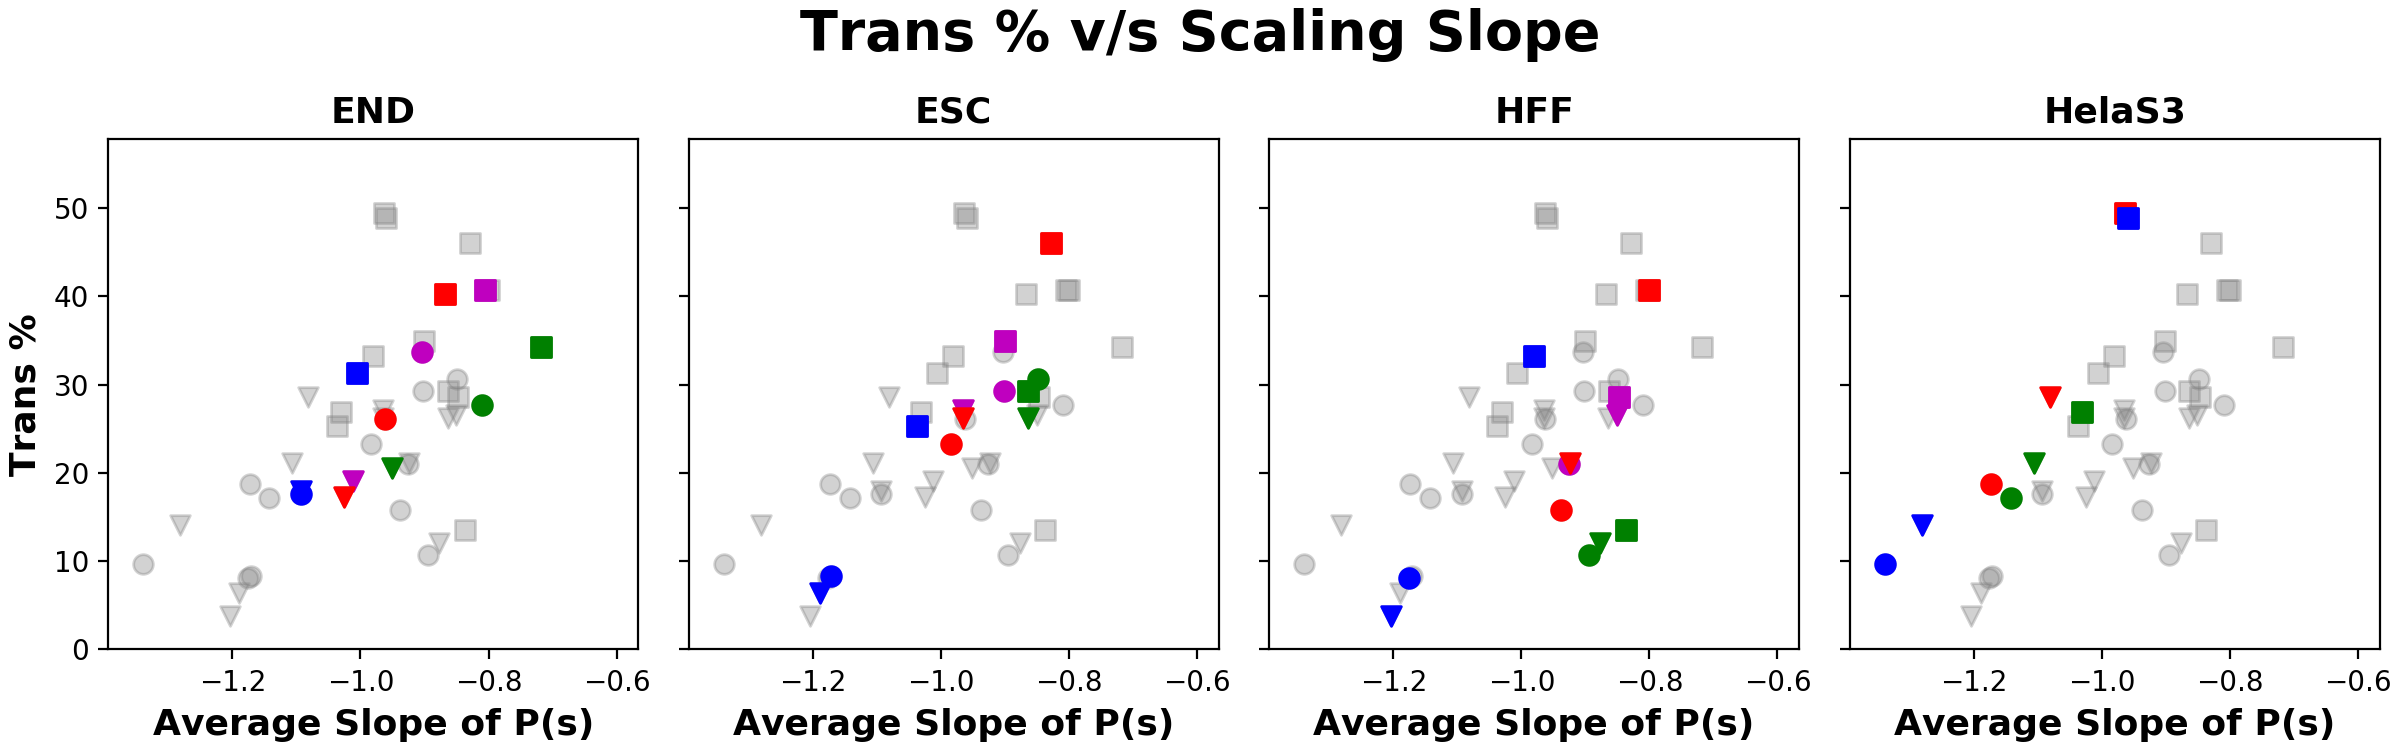

In [41]:
grey_alpha=0.35
enz_colors = {'MNase':'b','DdeI':'m','DpnII':'r','HindIII':'g'}
xl_markers = {'DSG':'o', 'EGS':'v','FA':'s'}
savepath = '/home/sameer/Dropbox (MIT)/Research/U54_matrix/scatterplots/draft_figs/cis_trans/'

df = mm.filter_data(table, filter_dict={'seq':['control','-'], 'cycle':'NS'})

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(12,3.75), sharex=True, sharey=True, constrained_layout=True)
fig.suptitle('Trans % v/s Scaling Slope', fontsize=20, fontweight='bold')
ax[0].set_ylabel('Trans %', fontsize=13, fontweight='bold')

x = df['mean_slope'].values
y = df['cis_trans'].values
y = 100/(1+y)
mux = np.mean(x)
sdx = np.sqrt(np.var(x))
muy = np.mean(y)
sdy = np.sqrt(np.var(y))

for _, row in df.iterrows():
    xl = row['xlink']
    x1 = row['mean_slope']
    y1 = row['cis_trans']
    y1 = 100/(1+y1)
    for k in range(4):
        ax[k].scatter(x1, y1, color='grey', s=50, marker=xl_markers[xl], alpha=grey_alpha)
        
        
for i, (ct, big_group) in enumerate(df.groupby('celltype')):
    ax[i].set_title(f'{ct}', fontsize=13, fontweight='bold')
    ax[i].set_xlabel('Average Slope of P(s)', fontsize=13, fontweight='bold') 
    ax[i].set_xlim([mux-3*sdx, mux+3*sdx])
    ax[i].set_ylim([0, muy+3*sdy])

    for enz, lil_group in big_group.groupby('enzyme'):
        
        for _, row in lil_group.iterrows():
            xl = row['xlink']
            x1 = row['mean_slope']
            y1 = row['cis_trans']
            y1 = 100/(1+y1)
            ax[i].scatter(x1, y1, s=50, color=enz_colors[enz], marker=xl_markers[xl], label=f'{xl}-{enz}')
    
fig.savefig(f'{savepath}scatter_trans%_v_slope_protocol_v2.pdf', format='pdf')

<IPython.core.display.Javascript object>


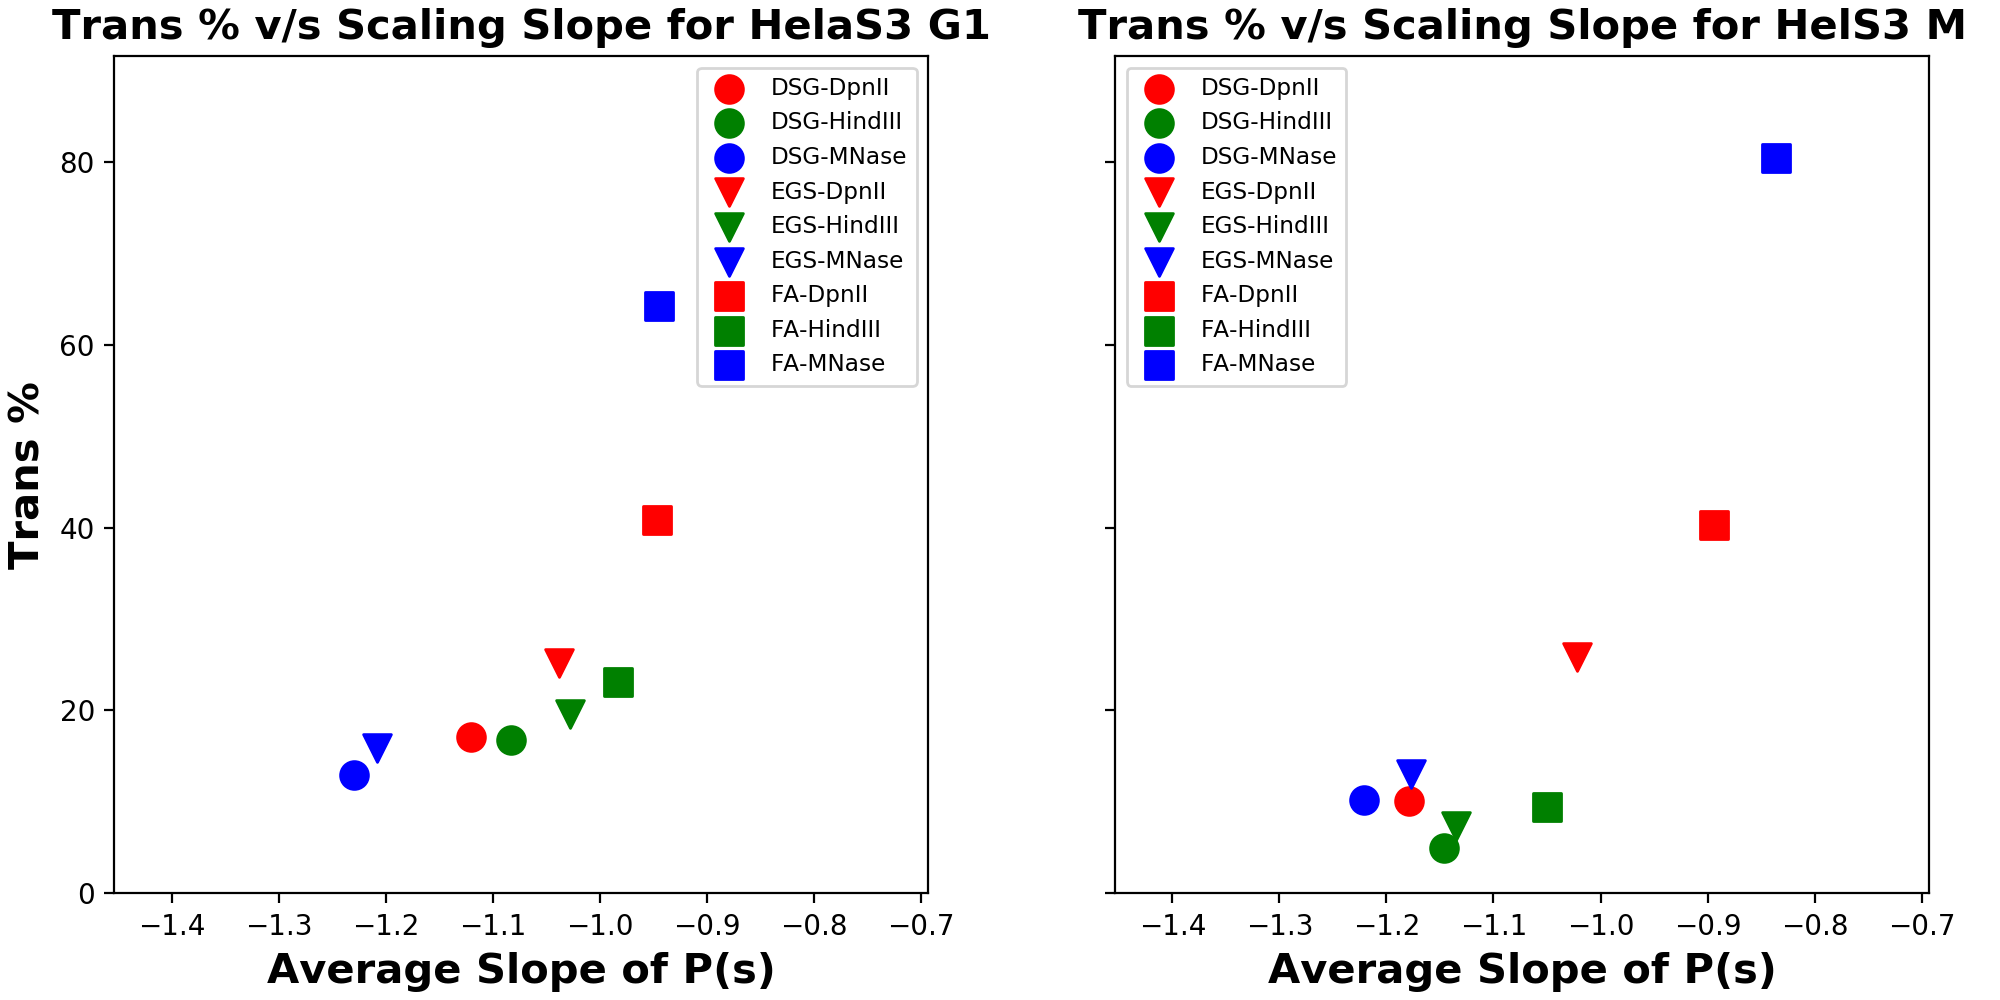

In [65]:
df = mm.filter_data(table, filter_dict={'celltype':'HelaS3','seq':['control','-'], 'cycle':'G1'}).sort_index()
fig, ax = plt.subplots(ncols=2, figsize=(10,5), sharex=True, sharey=True, constrained_layout=True)

colors = {'MNase':'b','DdeI':'m','DpnII':'r','HindIII':'g'}
markers = {'DSG':'o', 'EGS':'v','FA':'s'}

y_col = 'cis_trans'
y = df[y_col].values
y = 100/(1+y)
x = df['mean_slope'].values
mu = np.mean(x)
sd = np.sqrt(np.var(x))
ax[0].set_xlim([mu-3*sd, mu+3*sd])
mu = np.mean(y)
sd = np.sqrt(np.var(y))
ax[0].set_ylim([0, mu+3*sd])

for _, row in df.iterrows():
    xl = row['xlink']
    enz = row['enzyme']
    x1 = row['mean_slope']
    y1 = row[y_col]
    y1 = 100/(1+y1)
    ax[0].scatter(x1, y1, s=100, color=colors[enz], marker=markers[xl], label=f'{xl}-{enz}')

ax[0].legend(loc='best', fontsize='small')

ax[0].set_title(f'Trans % v/s Scaling Slope for HelaS3 G1', fontsize=15, fontweight='bold')
ax[0].set_xlabel('Average Slope of P(s)', fontsize=15, fontweight='bold')  
ax[0].set_ylabel('Trans %', fontsize=15, fontweight='bold')


df = mm.filter_data(table, filter_dict={'celltype':'HelaS3','seq':['control','-'], 'cycle':'M'}).sort_index()

colors = {'MNase':'b','DdeI':'m','DpnII':'r','HindIII':'g'}
markers = {'DSG':'o', 'EGS':'v','FA':'s'}

y = df[y_col].values
y = 100/(1+y)
x = df['mean_slope'].values
mu = np.mean(x)
sd = np.sqrt(np.var(x))
ax[1].set_xlim([mu-3*sd, mu+3*sd])
mu = np.mean(y)
sd = np.sqrt(np.var(y))
ax[1].set_ylim([0, mu+3*sd])

for _, row in df.iterrows():
    xl = row['xlink']
    enz = row['enzyme']
    x1 = row['mean_slope']
    y1 = row[y_col]
    y1 = 100/(1+y1)
    ax[1].scatter(x1, y1, s=100, color=colors[enz], marker=markers[xl], label=f'{xl}-{enz}')

ax[1].legend(loc='best', fontsize='small')

ax[1].set_title(f'Trans % v/s Scaling Slope for HelS3 M', fontsize=15, fontweight='bold')
ax[1].set_xlabel('Average Slope of P(s)', fontsize=15, fontweight='bold')  
savepath = '/home/sameer/Dropbox (MIT)/Research/U54_matrix/scatterplots/draft_figs/cis_trans/'
# fig.savefig(f'{savepath}scatter_trans%_v_slope_HelaS3.pdf', format='pdf')

In [43]:
df

,lib_name,seq,celltype,xlink,enzyme,cycle,mean_slope,mean_trans,cis_trans,mean_slope_short,mean_slope_med,mean_slope_long,sd_slope,sd_trans
47,U54-HelaS3-M-DSG-DpnII-20180709-R1-T1__hg38,-,HelaS3,DSG,DpnII,M,-1.179013,3.568682e-08,8.242911,-1.050610,-0.545449,-1.947737,0.733495,6.788032e-09
50,U54-HelaS3-M-DSG-HindIII-20180730-R1-T1__hg38,-,HelaS3,DSG,HindIII,M,-1.145877,4.917762e-08,18.020338,-0.877036,-0.523817,-2.050929,0.835909,1.807530e-08
53,U54-HelaS3-M-DSG-MNase-08072018-R1-T1__hg38,-,HelaS3,DSG,MNase,M,-1.221211,3.514208e-08,8.148556,-1.261987,-0.568162,-1.831338,0.691989,6.749359e-09
56,U54-HelaS3-M-EGS-DpnII-20180709-R1-T1__hg38,-,HelaS3,EGS,DpnII,M,-1.021639,8.819545e-08,2.577110,-0.913974,-0.514790,-1.641819,0.585556,1.166761e-08
59,U54-HelaS3-M-EGS-HindIII-20180730-R1-T1__hg38,-,HelaS3,EGS,HindIII,M,-1.135164,6.669489e-08,11.556470,-0.839815,-0.510510,-2.070712,0.861591,2.330134e-08
62,U54-HelaS3-M-EGS-MNase-08072018-R1-T1__hg38,-,HelaS3,EGS,MNase,M,-1.176593,5.098972e-08,8.030632,-1.236107,-0.703973,-1.586567,0.684699,4.851767e-09
65,U54-HelaS3-M-FA-DpnII-20180709-R1-T1__hg38,-,HelaS3,FA,DpnII,M,-0.893904,1.361476e-07,1.307503,-0.852152,-0.490466,-1.341291,0.451389,1.939306e-08
69,U54-HelaS3-M-FA-HindIII-20180730-R1-T1__hg38,-,HelaS3,FA,HindIII,M,-1.049798,8.200227e-08,8.911115,-0.732443,-0.494121,-1.939531,0.802135,2.530558e-08
72,U54-HelaS3-M-FA-MNase-08072018-R1-T1__hg38,-,HelaS3,FA,MNase,M,-0.835977,3.345365e-07,0.214778,-1.272088,-0.594563,-0.618326,0.477854,6.516069e-09


In [ ]:
imp.reload(mm)
db = mm.Dataset()
table = db.get_tables()
table = mm.filter_data(table, filter_dict={'seq':'deep', 'xlink':'FA','enzyme':'DpnII'})

fig, ax = plt.subplots(figsize=(9.5,6), nrows=2, ncols=2, sharex=False, sharey=False, constrained_layout=False)
ax = ax.ravel()

cmap = matplotlib.cm.get_cmap('plasma')
for i, ct in enumerate(['HFF', 'HelaS3', 'END','ESC']):
    display(ct)
    df = mm.filter_data(table, filter_dict={'celltype':ct})
    df = mm.get_scalings(df, trans=False)
    df = mm.get_coolers(df, res=1000000)
    cool = df.iloc[0]['cooler_1000000']
    scale = df.iloc[0]['scaling'].load().reset_index()
    scale['chrom'] = scale['region'].apply(lambda x: bioframe.parse_region_string(x)[0])
    scale = scale.groupby(['chrom','diag']).sum()
    scale = scale.reset_index()

    ax[i].set_title(ct, fontweight='bold')
    if i == 2 or i == 3:
        ax[i].set_xlabel('Slope', fontweight='bold')
    if i == 0 or i == 2:
        ax[i].set_ylabel('Trans %', fontweight='bold')
#     cmap = get_custom_cmap(23)
    j = 0
    for chrom, group in scale.groupby('chrom'):
        if chrom in ['chrY','chrM']:
            continue  
        chr_list.append(chrom)

        group = group.set_index('diag')
        group = group.drop([0,1000])
        group = new_scalings.log_binning(group.copy())
        group['prob'] = group['total']/group['valid_bins']

        der = np.mean(scaling_analysis.finite_difference(group, 1).values.flatten())
        slope.append(der)

        pix = cool.pixels()[:]
        bins = cool.bins()[:]
        pix = cooler.annotate(pix, bins, replace=True)
        mask1 = pix.chrom1.apply(lambda x: x == chrom)
        mask2 = pix.chrom2.apply(lambda x: x == chrom)
        pix = pix.loc[mask1 | mask2]

        cis = pix.loc[pix['chrom1'] == pix['chrom2'], 'count'].sum()
        trans = pix.loc[pix['chrom1'] != pix['chrom2'], 'count'].sum()   
        ptrans = 100*trans/(cis+trans)
        trans_list.append(ptrans)

        ax[i].scatter(der, ptrans, color = cmap(j/23), label=chrom)
        j += 1
    if i==1:
        ax[i].legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1)

fig.savefig('/home/sameer/Dropbox (MIT)/Research/U54_matrix/trans_slope_by_chrom.png', format='png')

In [ ]:

cmap(23)

In [ ]:
scale